#CNN - Melonama Detect

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


###Importing all the important libraries

In [1]:

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

###Connecting to gdrive

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## The paths of the train and test dataset

root_path = '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
## Get Number of images in Train and Test folders

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



2239
118


###Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

###Create a dataset

Define some parameters for the loader:

In [5]:
## Defining the image parameters

batch_size = 32
img_height = 180
img_width = 180



In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6126 files belonging to 9 classes.
Using 4901 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6126 files belonging to 9 classes.
Using 1225 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


###Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

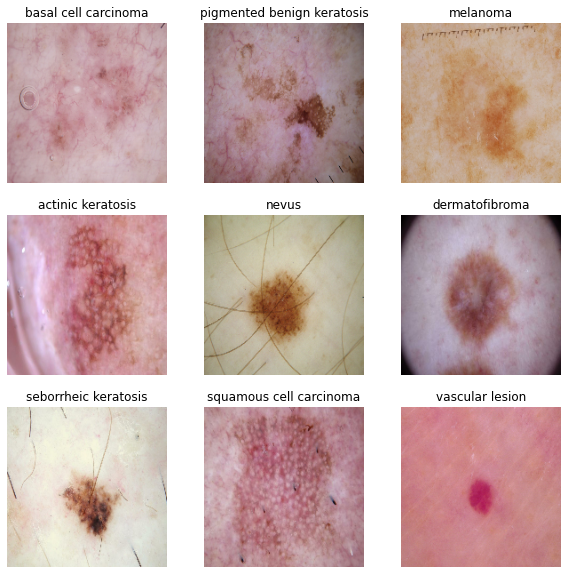

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
new_class = []
image_count = 0
for images, labels in train_ds.take(10):
    for i in range(32):
        if class_names[labels[i]] not in new_class:
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            new_class.append(class_names[labels[i]])
            image_count += 1

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the Model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:
### Your code goes here

input_shape = (img_height, img_width, 3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Conv Layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
#Second Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Third Conv layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#Fourth Conv layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9))


###Compile the model

Choose an appropirate optimiser and loss function for model training

In [12]:
### Choosing appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 module_wrapper (ModuleWrapp  (None, 45, 45, 32)       0         
 er)                                                    

###Train the Model

In [14]:
#For 20 Epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
154/154 [==============================] - 642s 941ms/step - loss: 1.8748 - accuracy: 0.2869 - val_loss: 1.6607 - val_accuracy: 0.3371
Epoch 2/20
154/154 [==============================] - 6s 41ms/step - loss: 1.5925 - accuracy: 0.3989 - val_loss: 1.6255 - val_accuracy: 0.3951
Epoch 3/20
154/154 [==============================] - 6s 40ms/step - loss: 1.4065 - accuracy: 0.4783 - val_loss: 1.3665 - val_accuracy: 0.4792
Epoch 4/20
154/154 [==============================] - 6s 40ms/step - loss: 1.1840 - accuracy: 0.5670 - val_loss: 1.1660 - val_accuracy: 0.5771
Epoch 5/20
154/154 [==============================] - 6s 40ms/step - loss: 0.9328 - accuracy: 0.6676 - val_loss: 1.0957 - val_accuracy: 0.6090
Epoch 6/20
154/154 [==============================] - 6s 40ms/step - loss: 0.7181 - accuracy: 0.7501 - val_loss: 0.9449 - val_accuracy: 0.6596
Epoch 7/20
154/154 [==============================] - 6s 40ms/step - loss: 0.5339 - accuracy: 0.8058 - val_loss: 1.0157 - val_accuracy: 0.6

###Visualizing training results

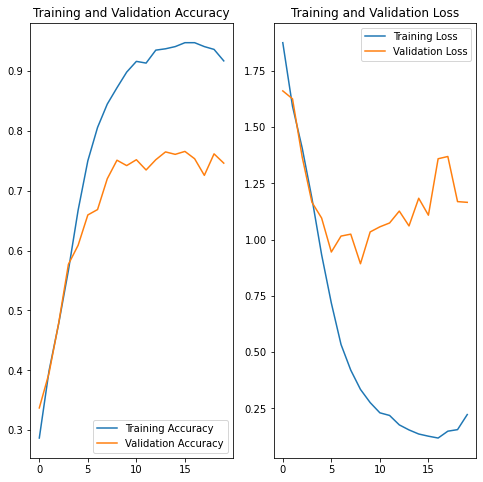

In [15]:
#Visualize Accuracy of Training vs Validity

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



###Finding after running the Model


We can get following observation from Model:

1. The Model is overfitting as it has performed well on training (89.45% accuracy) but not performed in Validation set(52.13% accuracy).
2. Loss in Validation setis than loss is training dataset 

In [16]:
#We analysed the model fit history for presence of underfit or overfit

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


39/39 [==============================] - 1s 16ms/step - loss: 1.1656 - accuracy: 0.7461
Accuracy:  0.9514384865760803
Validation Accuracy:  0.746122419834137
Loss:  0.12827302515506744
Validation Loss 1.1655982732772827


In [17]:
from tensorflow.keras.models import Sequential

augment = keras.models.Sequential(
	[ 
		layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(180, 180, 3)),
		layers.experimental.preprocessing.RandomRotation(0.2),
		layers.experimental.preprocessing.RandomZoom(0.1),
	]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


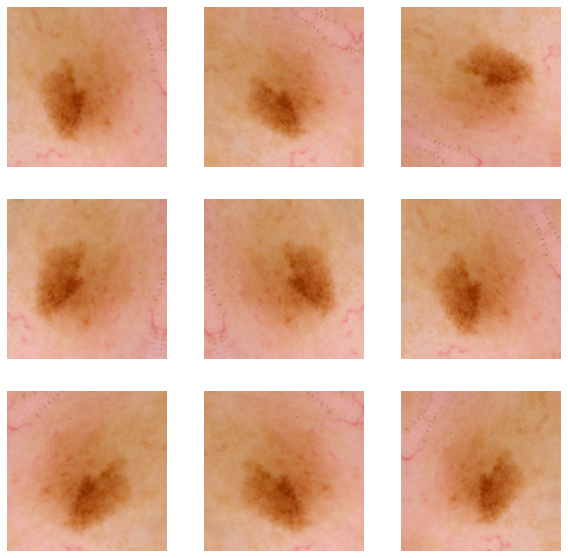

In [18]:
plt.figure(figsize=(10, 10)) 
for images, labels in train_ds.take(10): 
	for i in range(9): 
		augmented_image = augment(images) 
		ax = plt.subplot(3, 3, i + 1) 
		plt.imshow(augmented_image[0].numpy().astype("uint8")) 
		plt.axis("off")

##Create the model, compile and train the model

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

input_shape = (img_height, img_width, 3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Conv Layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
#Second Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Third Conv layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fourth Conv layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(9))


###Compile Model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 module_wrapper_5 (ModuleWra  (None, 90, 90, 16)       0         
 pper)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)       

###Training the Model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
154/154 [==============================] - 7s 43ms/step - loss: 2.1747 - accuracy: 0.1492 - val_loss: 2.1332 - val_accuracy: 0.1829
Epoch 2/20
154/154 [==============================] - 7s 42ms/step - loss: 2.0697 - accuracy: 0.1898 - val_loss: 1.9945 - val_accuracy: 0.2522
Epoch 3/20
154/154 [==============================] - 7s 42ms/step - loss: 1.9588 - accuracy: 0.2487 - val_loss: 1.8734 - val_accuracy: 0.2808
Epoch 4/20
154/154 [==============================] - 6s 42ms/step - loss: 1.8321 - accuracy: 0.2883 - val_loss: 1.7549 - val_accuracy: 0.3314
Epoch 5/20
154/154 [==============================] - 7s 42ms/step - loss: 1.7171 - accuracy: 0.3293 - val_loss: 1.7024 - val_accuracy: 0.3273
Epoch 6/20
154/154 [==============================] - 6s 42ms/step - loss: 1.6540 - accuracy: 0.3481 - val_loss: 1.6051 - val_accuracy: 0.3600
Epoch 7/20
154/154 [==============================] - 6s 42ms/step - loss: 1.6128 - accuracy: 0.3630 - val_loss: 1.6577 - val_accuracy: 0.3429

###Visualizing the Results

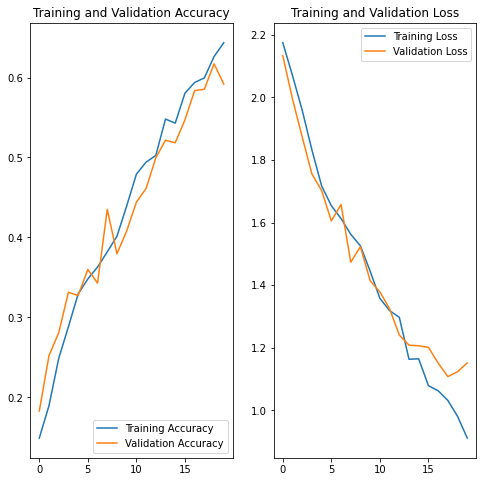

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Finding after running model with dropout

1. Gap between training and Validation is lower, however accuracy rate is 60% in training and 53% in validation
2. Loss & Validation loss is under 1.5% 
3. No sign of overfitting or underfitting

###Augment and Visualize in Model 2

In [24]:
# Code will flip, rotate and zoom randomly
from tensorflow.keras.models import Sequential

augment = keras.models.Sequential(
	[ 
		layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(180, 180, 3)),
		layers.experimental.preprocessing.RandomRotation(0.2),
		layers.experimental.preprocessing.RandomZoom(0.1),
	]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


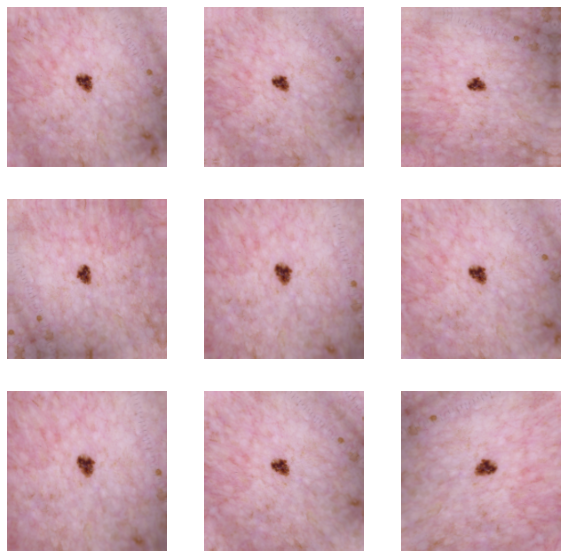

In [25]:
#View images
plt.figure(figsize=(10, 10)) 
for images, labels in train_ds.take(10): 
	for i in range(9): 
		augmented_image = augment(images) 
		ax = plt.subplot(3, 3, i + 1) 
		plt.imshow(augmented_image[0].numpy().astype("uint8")) 
		plt.axis("off")

### Glacing at Class Imbalance

In [26]:
class_count ={}
path_to_train='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
for i in class_names:
	data_dir = pathlib.Path(path_to_train + i)
	image_count = len(list(data_dir.glob('*.jpg')))
	class_count[i] = image_count

df = pd.DataFrame(class_count.values(), index=class_count.keys(), columns=['count'])
df['percentage'] = round(100*df['count']/df['count'].sum(),1)
print(df.sort_values(by=['count'],ascending=False))

                            count  percentage
pigmented benign keratosis    462        20.6
melanoma                      438        19.6
basal cell carcinoma          376        16.8
nevus                         357        15.9
squamous cell carcinoma       181         8.1
vascular lesion               139         6.2
actinic keratosis             114         5.1
dermatofibroma                 95         4.2
seborrheic keratosis           77         3.4


##Steps to rectify the Class Imbalance

###Installing Augmentor

In [27]:
!pip install augmentor

###Running Augmentor to augment images for all the classes

In [28]:
path_to_training_dataset=path_to_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE60C097C90>: 100%|██████████| 500/500 [00:20<00:00, 23.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60C144E50>: 100%|██████████| 500/500 [00:21<00:00, 23.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60C144F50>: 100%|██████████| 500/500 [00:22<00:00, 22.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE60668FED0>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x676 at 0x7FE60C0DE550>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6066DBE10>: 100%|██████████| 500/500 [00:19<00:00, 25.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE6066DB590>: 100%|██████████| 500/500 [00:43<00:00, 11.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60C05FE90>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE60672C790>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
# Count for total number of images

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

8387


###Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
import glob
from glob import glob


In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_a0faeb66-96dd-4200-9029-9b3fc6d70a34.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_fb1c96af-6b05-4251-b667-004594a9e920.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_83212e25-99bb-4178-8c0a-631219fd79b5.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_30334c63-1a46-45c5-83dd-4156a17b97fd.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:


dataframe_dict_new = dict(zip(path_list, lesion_list_new))



In [34]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [35]:
new_df['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma        887
vascular lesion                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##Model 3 - Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180


###Create a training dataset

In [37]:
#



data_dir_train=path_to_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 10626 files belonging to 9 classes.
Using 8501 files for training.


###Create a validation dataset

In [38]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 10626 files belonging to 9 classes.
Using 2125 files for validation.


###Create your model

In [39]:

input_shape = (img_height, img_width, 3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Conv Layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))

#Second Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Third Conv layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fourth Conv layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(9))

###Compile your model

In [40]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [41]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 16)      

###Train your model

In [ ]:


epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) # your model fit code



Epoch 1/30
266/266 [==============================] - 62s 225ms/step - loss: 1.7544 - accuracy: 0.3875 - val_loss: 24.8578 - val_accuracy: 0.0993
Epoch 2/30
266/266 [==============================] - 47s 171ms/step - loss: 1.3157 - accuracy: 0.5245 - val_loss: 2.3900 - val_accuracy: 0.2569
Epoch 3/30
266/266 [==============================] - 48s 179ms/step - loss: 1.0769 - accuracy: 0.6143 - val_loss: 11.9160 - val_accuracy: 0.3854
Epoch 4/30
266/266 [==============================] - 46s 169ms/step - loss: 0.8759 - accuracy: 0.6844 - val_loss: 1.0725 - val_accuracy: 0.6306
Epoch 5/30
266/266 [==============================] - 46s 170ms/step - loss: 0.6773 - accuracy: 0.7524 - val_loss: 0.8953 - val_accuracy: 0.6744
Epoch 6/30
266/266 [==============================] - 47s 172ms/step - loss: 0.5469 - accuracy: 0.8032 - val_loss: 0.8958 - val_accuracy: 0.6809
Epoch 7/30
266/266 [==============================] - 47s 172ms/step - loss: 0.4634 - accuracy: 0.8351 - val_loss: 0.7877 - val_

###Visualize the model results

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



###Finding after Model 3

1. Training and Validation has significant improvements
2. Loss is low on Training and Spikes in Validation set
3. Accuracy is around 94% in training and validation has around 79% accuracy.